In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import *
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [57]:
# load csv of tape data
raw_data = read_merged_data()
tape1 = raw_data[0]
tape1 = tape1.dropna(subset=["Last Tapes Price"])

Opening UoB_Set01_2025-01-02tapes.csv


In [58]:
print(tape1.head())

                                      Incoming bid  \
combined_time                                        
2025-01-02 08:00:10                [193 15][267 5]   
2025-01-02 08:00:11  [118 10][267 3][96 10][46 10]   
2025-01-02 08:00:12   [92 10][127 1][264 1][181 1]   
2025-01-02 08:00:13                                  
2025-01-02 08:00:14                        [10 10]   

                                                          Incoming ask  \
combined_time                                                            
2025-01-02 08:00:10               [275 8] [277 2][584 3][269 1][268 1]   
2025-01-02 08:00:11  [281 6][274 3] [275 5][270 5][464 3][273 3][30...   
2025-01-02 08:00:12                      [744 3][270 3][280 4] [281 2]   
2025-01-02 08:00:13                       [269 3][282 2][268 3][278 4]   
2025-01-02 08:00:14  [272 5][296 3][271 5][423 5][270 3][644 5][376...   

                               Outgoing bid  \
combined_time                                 
2025-01-

<AxesSubplot:xlabel='combined_time'>

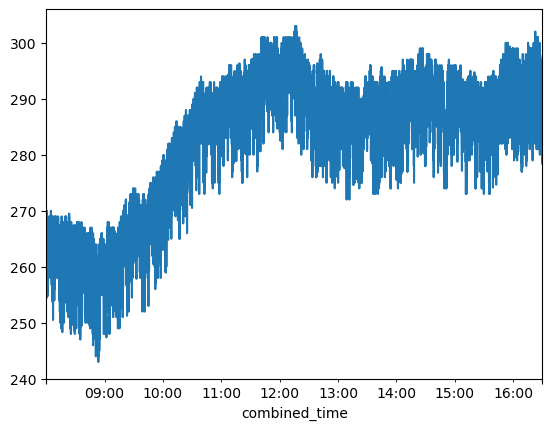

In [59]:
tape1['Last Tapes Price'].plot()

In [60]:
result = adfuller(tape1['Last Tapes Price'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -3.853514
p-value: 0.002405


As p-value is less than 0.05 then model can be assumed stationary and no differencing is needed - this may not hold for less granular data

In [61]:
from pmdarima.arima.utils import ndiffs
ndiffs(tape1['Last Tapes Price'].dropna(), test='adf')

0

Confirm the significant number of differencing is 0.

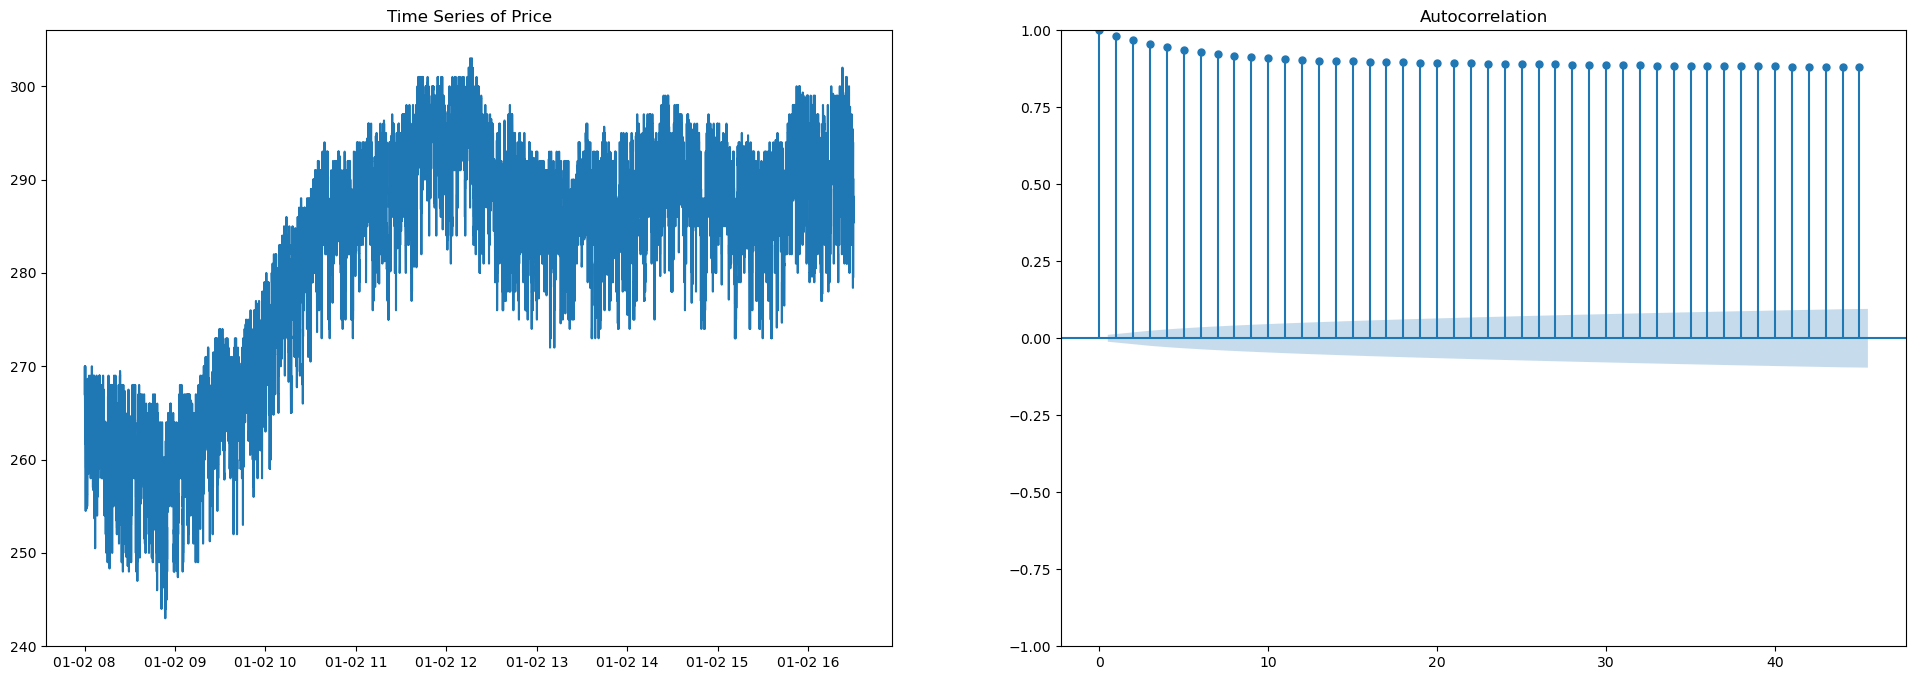

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(tape1['Last Tapes Price'])
ax1.set_title('Time Series of Price')
plot_acf(tape1['Last Tapes Price'], ax=ax2);

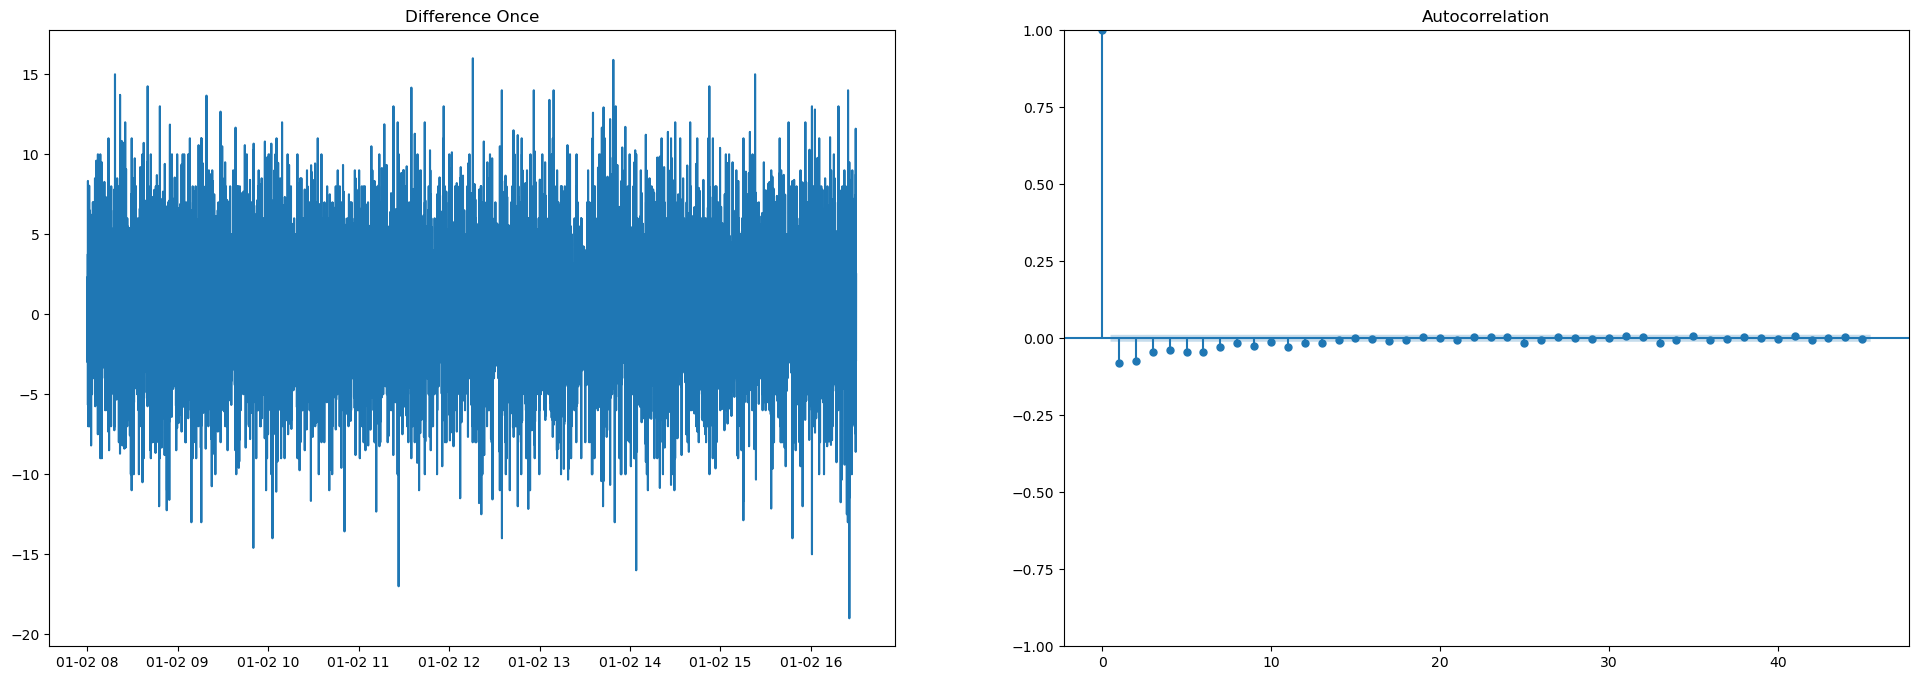

In [63]:
diff = tape1['Last Tapes Price'].diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);

Differencing provides a series more celearly centred around mean 0. This will be used for the further investigation despite the original data passing the ADF test. 

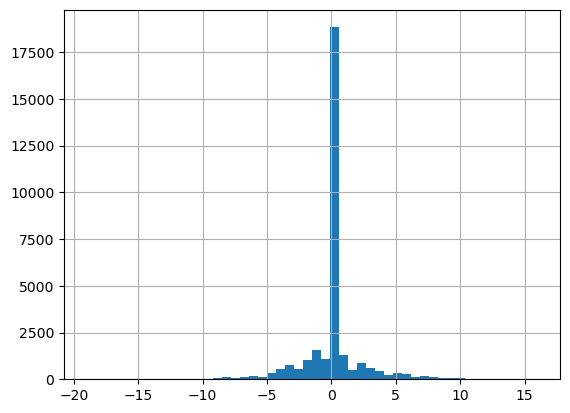

In [64]:
# histogram of differences
diff.hist(bins=50);

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


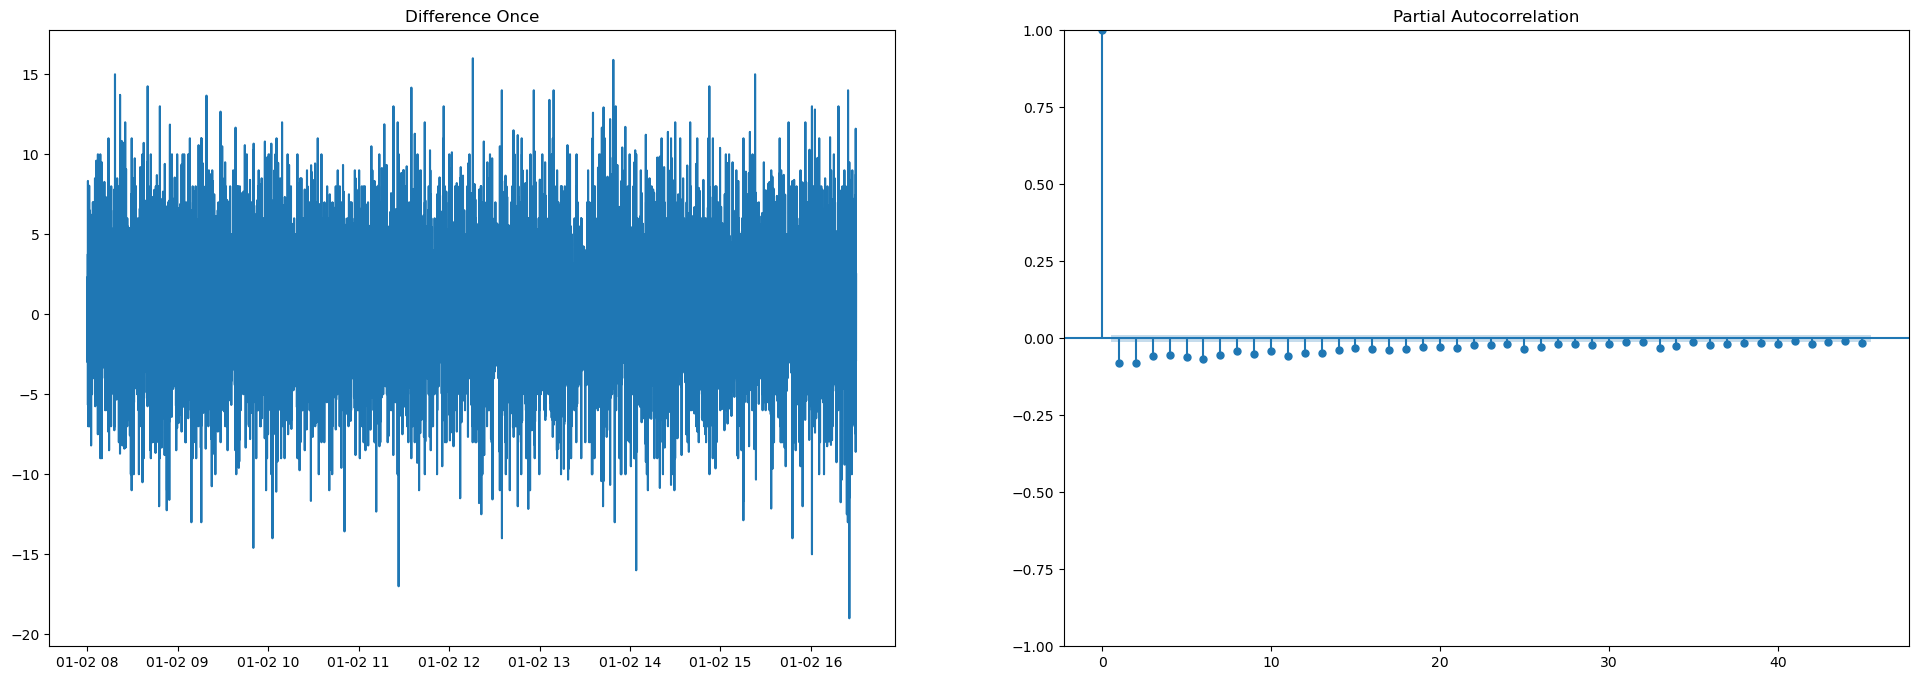

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_pacf(diff, ax=ax2);

Significant lags in the Auto-Regressive model which begin to die down at order 18. This pacf plot can be used to select the p value of the model.

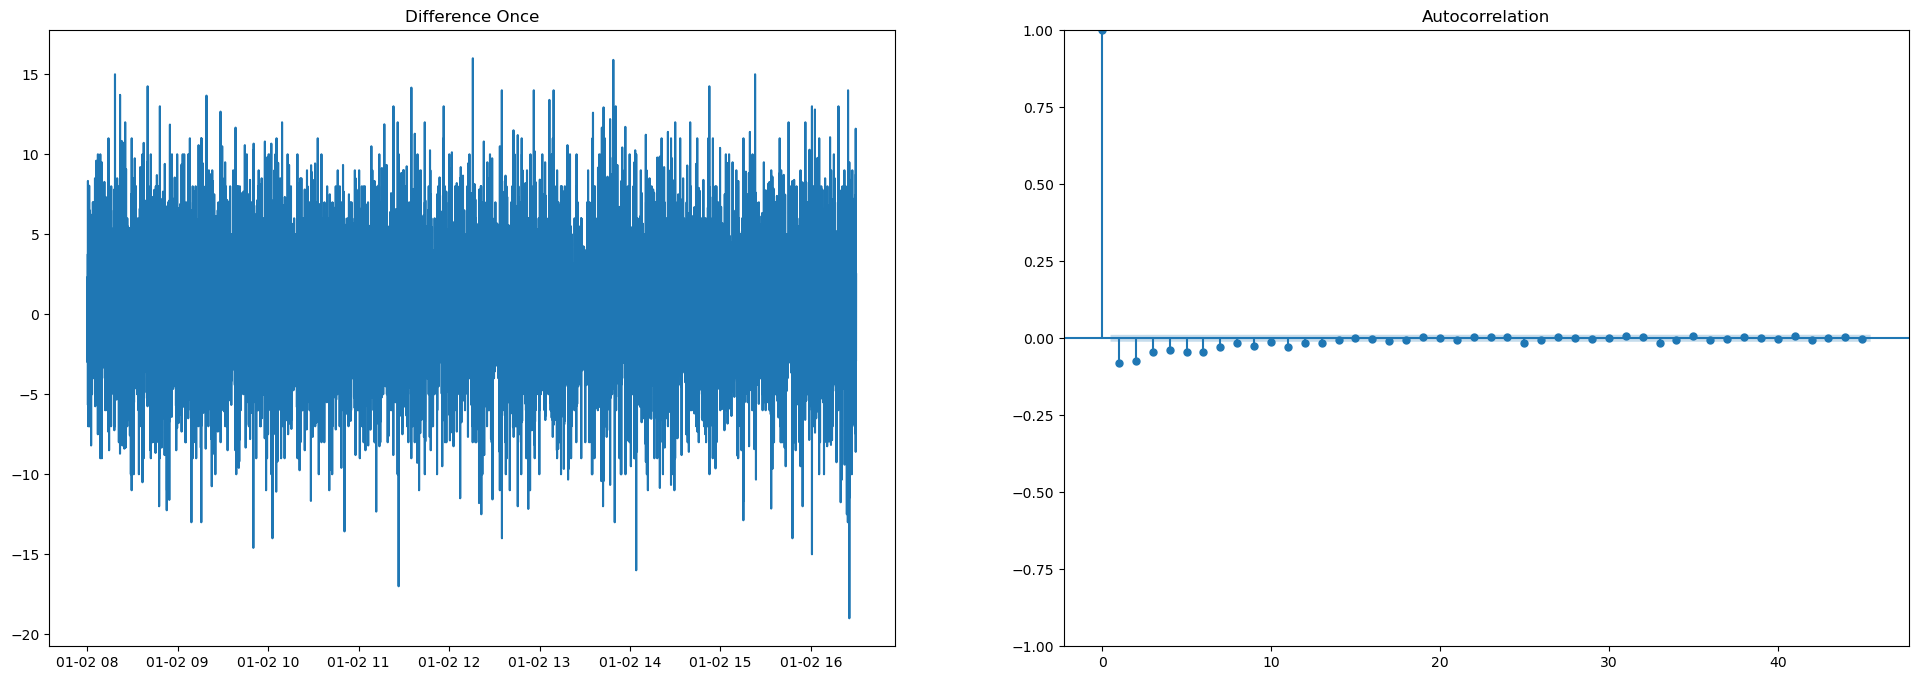

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff)
ax1.set_title('Difference Once')
plot_acf(diff, ax=ax2);


Significant lags in Moving Average model until lag 6. This can be used to choose q.

In [67]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model
model = ARIMA(tape1['Last Tapes Price'], order=(1,0,1))
result = model.fit()

Experimenting with standard (1,0,1) ARIMA model

In [68]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:       Last Tapes Price   No. Observations:                30590
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -68965.168
Date:                Wed, 06 Mar 2024   AIC                         137938.336
Time:                        16:43:08   BIC                         137971.650
Sample:                    01-02-2025   HQIC                        137949.015
                         - 01-02-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.6643      0.850    331.502      0.000     279.999     283.330
ar.L1          0.9856      0.001   1007.350      0.000       0.984       0.988
ma.L1         -0.0854      0.006    -14.916      0.0

Coefficient values are too small and P values are far too high, meaning the components of the model aer not significant enough so need to increase order of AR model and test performance again.

P values are much better in this model and coefficient values higher.

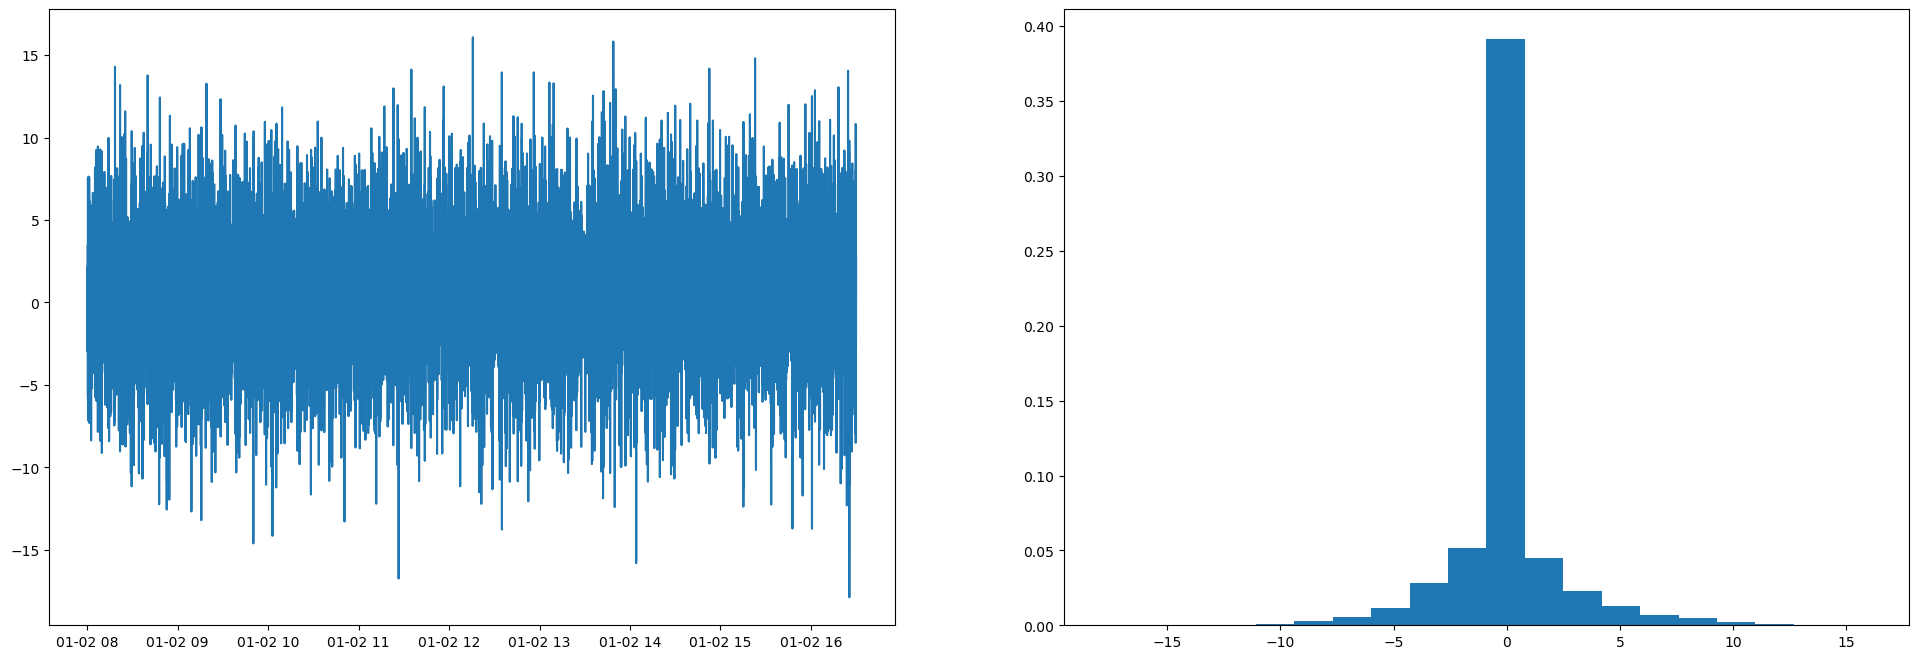

In [69]:
residuals = pd.DataFrame(result.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals[1:])
ax2.hist(residuals[1:], density=True, bins=20);



Text(0.5, 1.0, 'ARIMA Predictions for first 100 time stamps of Tape 1')

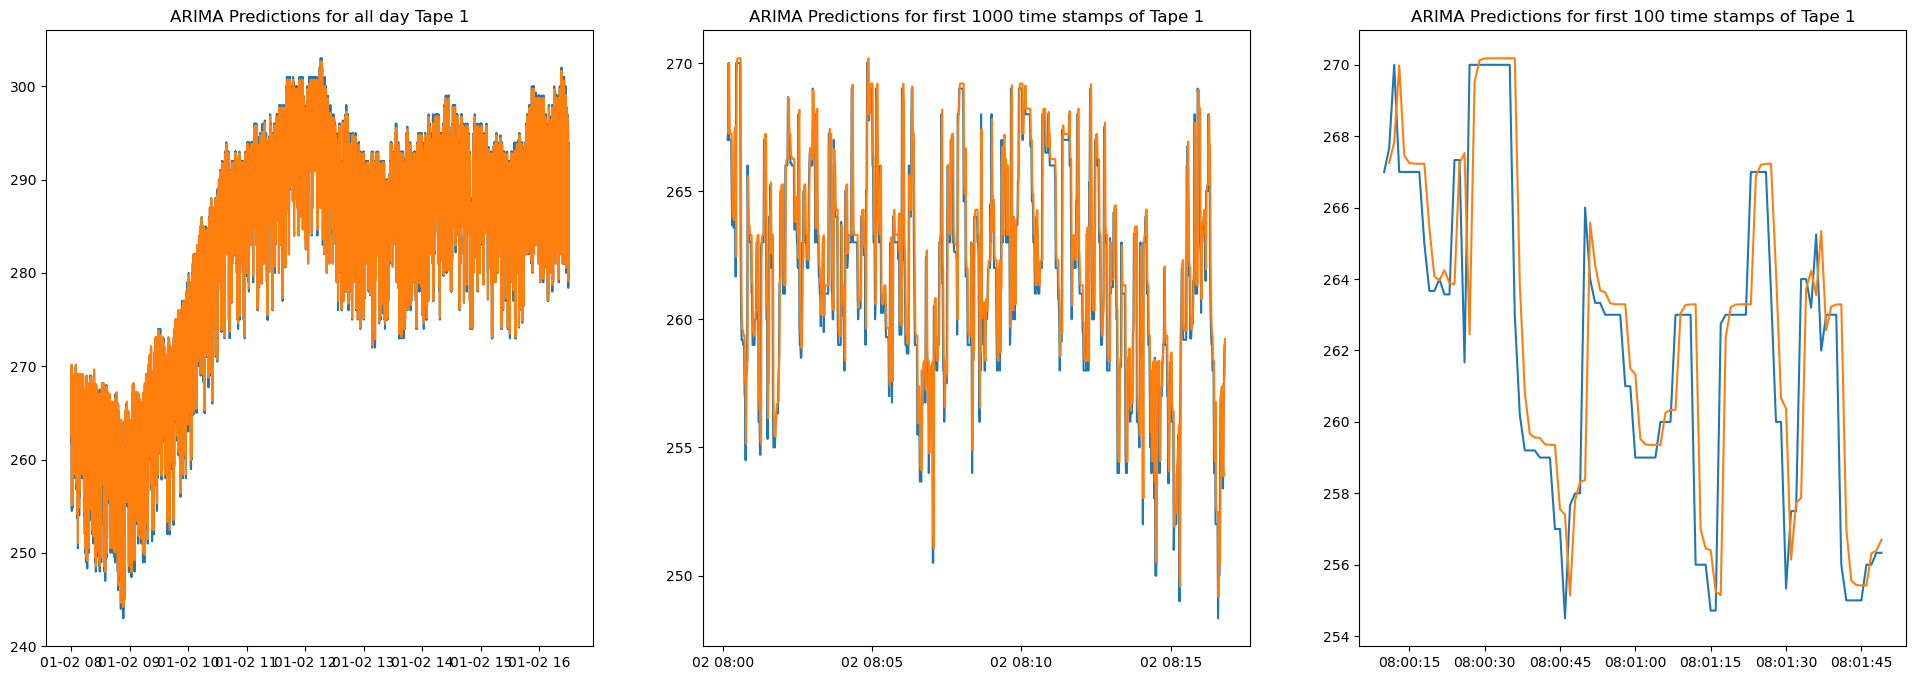

In [70]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))


pred = result.predict(start=0, end=len(tape1)-1)
ax1.plot(tape1['Last Tapes Price'])
ax1.plot(pred[1:])
ax1.set_title('ARIMA Predictions for all day Tape 1')

ax2.plot(tape1['Last Tapes Price'][:1000])
ax2.plot(pred[1:1000])
ax2.set_title('ARIMA Predictions for first 1000 time stamps of Tape 1')



ax3.plot(tape1['Last Tapes Price'][:100])
ax3.plot(pred[1:100]) 
ax3.set_title('ARIMA Predictions for first 100 time stamps of Tape 1')

Need to get the tapes 2 interpolated

In [71]:
raw_data_2 = read_merged_data(1)
tape2 = raw_data_2[0]
tape2 = tape2.dropna(subset=["Last Tapes Price"])

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv


Use the trained model and coefficients on a completely different day and see how it performs

In [72]:
result2 = result.apply(tape2['Last Tapes Price'], refit=False)

result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Last Tapes Price   No. Observations:                30590
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -68965.168
Date:                Wed, 06 Mar 2024   AIC                         137938.336
Time:                        16:43:13   BIC                         137971.650
Sample:                    01-02-2025   HQIC                        137949.015
                         - 01-02-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        281.6643      0.850    331.502      0.000     279.999     283.330
ar.L1          0.9856      0.001   1007.350      0.000       0.984       0.988
ma.L1         -0.0854      0.006    -14.916      0.000      -0.097      -0.074
sigma2         5.3175      0.022    241.828      0.000       5.274       5.361
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):             57225.74
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.36
Prob(H) (two-sided):                  0.24   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'ARIMA(1,0,1) Predictions for first 100 time stamps of Tape 2')

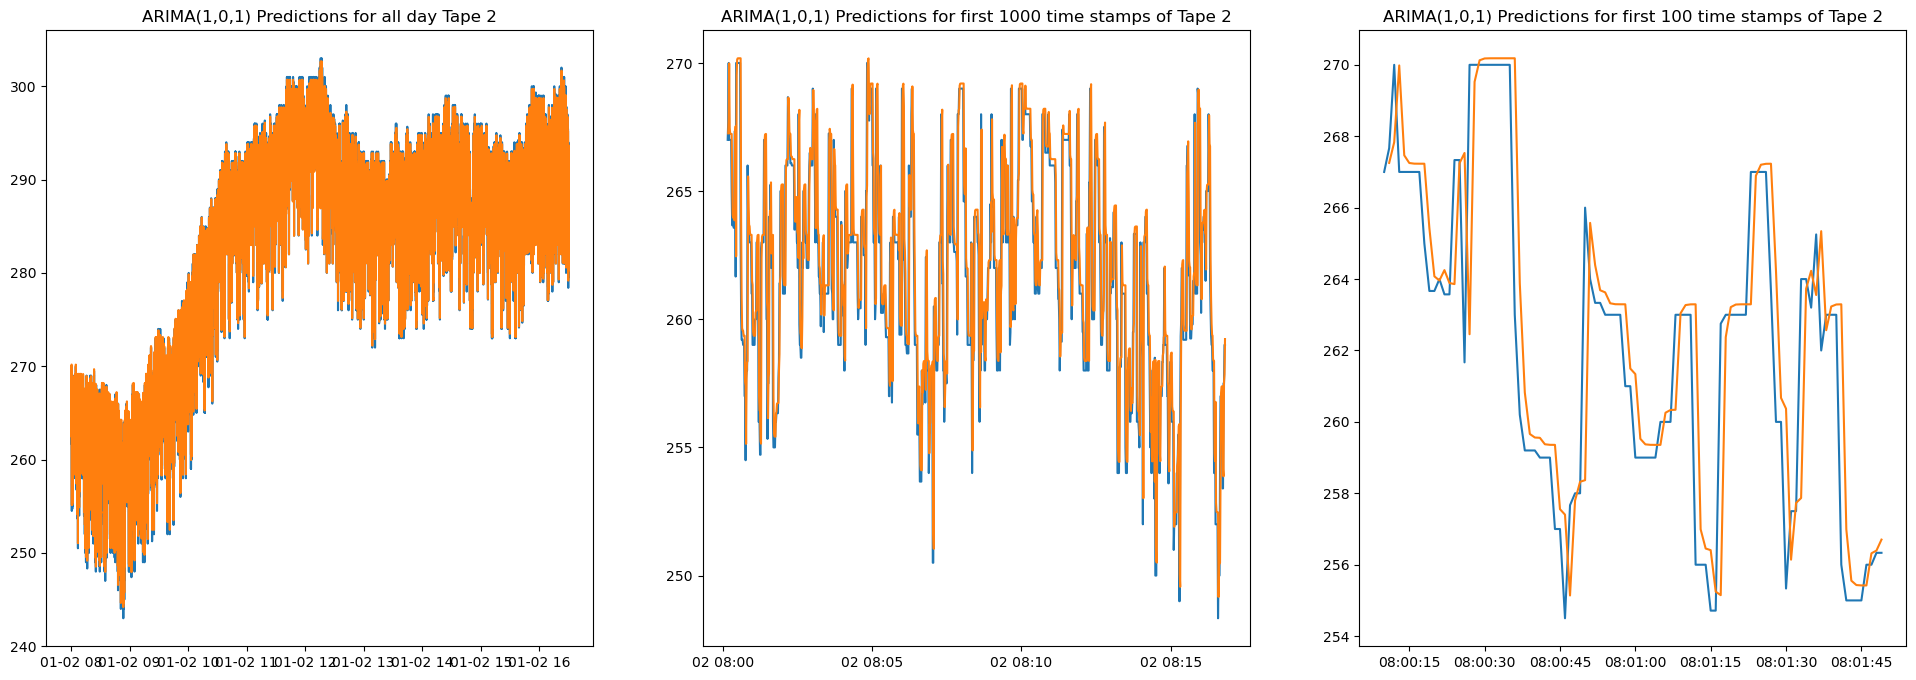

In [73]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

pred2 = result2.predict(start=0, end=len(tape2)-1)
ax1.plot(tape2['Last Tapes Price'])
ax1.plot(pred2[1:])
ax1.set_title('ARIMA(1,0,1) Predictions for all day Tape 2')

ax2.plot(tape2['Last Tapes Price'][:1000])
ax2.plot(pred2[1:1000])
ax2.set_title('ARIMA(1,0,1) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(tape2['Last Tapes Price'][:100])
ax3.plot(pred2[1:100]) 
ax3.set_title('ARIMA(1,0,1) Predictions for first 100 time stamps of Tape 2')

(array([3.84963331e-05, 3.84963331e-05, 1.15488999e-04, 4.23459664e-04,
        1.09714549e-03, 2.92572132e-03, 5.19700497e-03, 1.15296518e-02,
        2.83525493e-02, 5.19315534e-02, 3.91757934e-01, 4.52524396e-02,
        2.27320847e-02, 1.28962716e-02, 7.02558079e-03, 4.54256731e-03,
        1.96331299e-03, 5.77444997e-04, 3.27218832e-04, 5.77444997e-05]),
 array([-17.88453495, -16.18611394, -14.48769293, -12.78927193,
        -11.09085092,  -9.39242992,  -7.69400891,  -5.99558791,
         -4.2971669 ,  -2.5987459 ,  -0.90032489,   0.79809612,
          2.49651712,   4.19493813,   5.89335913,   7.59178014,
          9.29020114,  10.98862215,  12.68704315,  14.38546416,
         16.08388517]),
 <BarContainer object of 20 artists>)

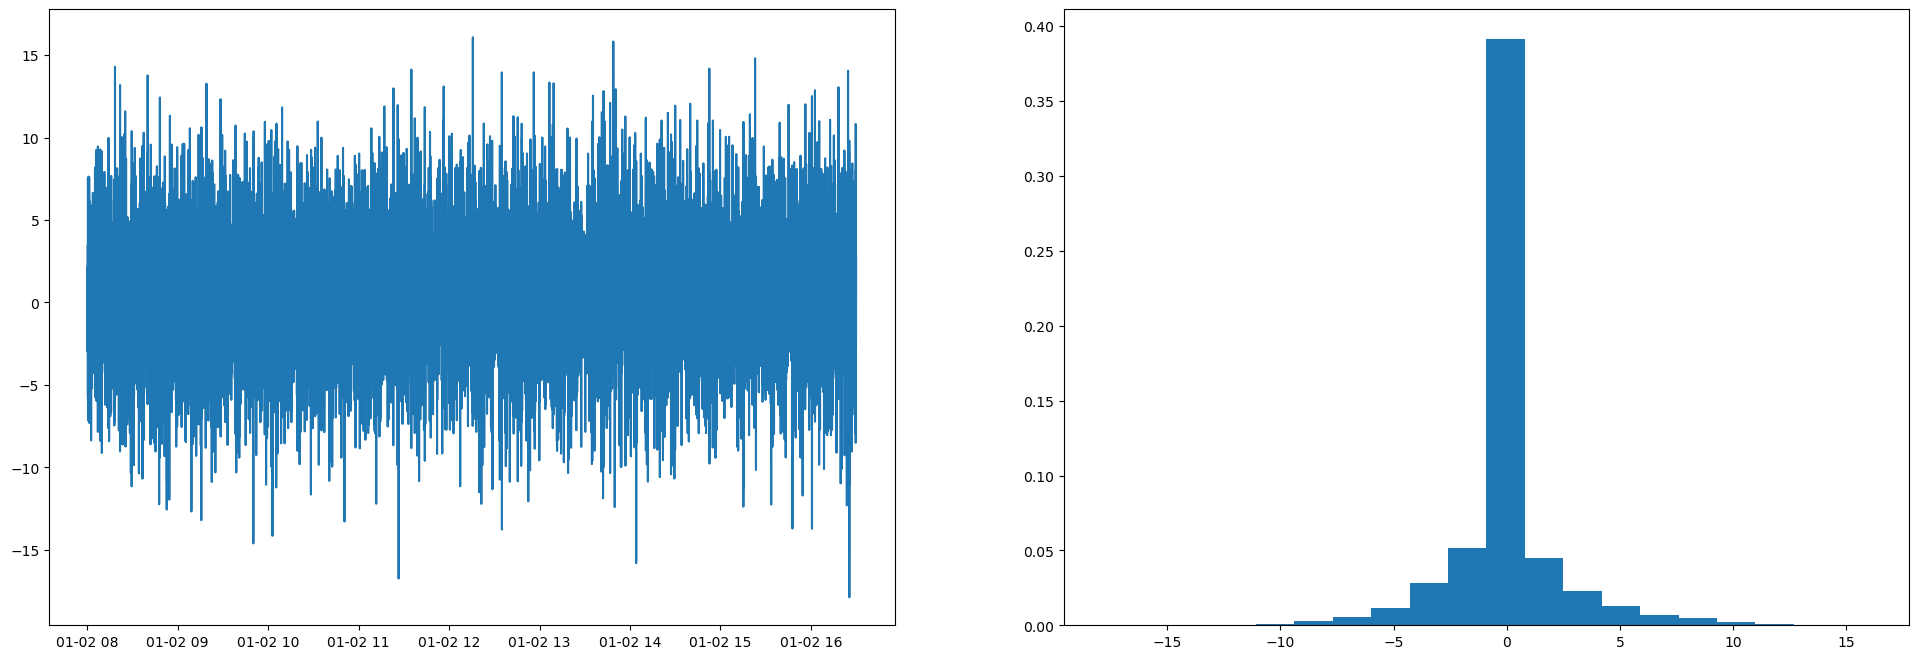

In [74]:
residuals2 = pd.DataFrame(result2.resid)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(residuals2[1:])
ax2.hist(residuals2[1:], density=True, bins=20)

Basic indicator using difference in price predicted

(array([3.18782180e-05, 2.86903962e-04, 2.05083203e-03, 8.22458025e-03,
        3.85513917e-02, 2.46726782e-01, 2.03701813e-02, 6.98132975e-03,
        1.56203268e-03, 2.44399672e-04]),
 array([-16.36245096, -13.28581482, -10.20917869,  -7.13254255,
         -4.05590642,  -0.97927028,   2.09736585,   5.17400198,
          8.25063812,  11.32727425,  14.40391039]),
 <BarContainer object of 10 artists>)

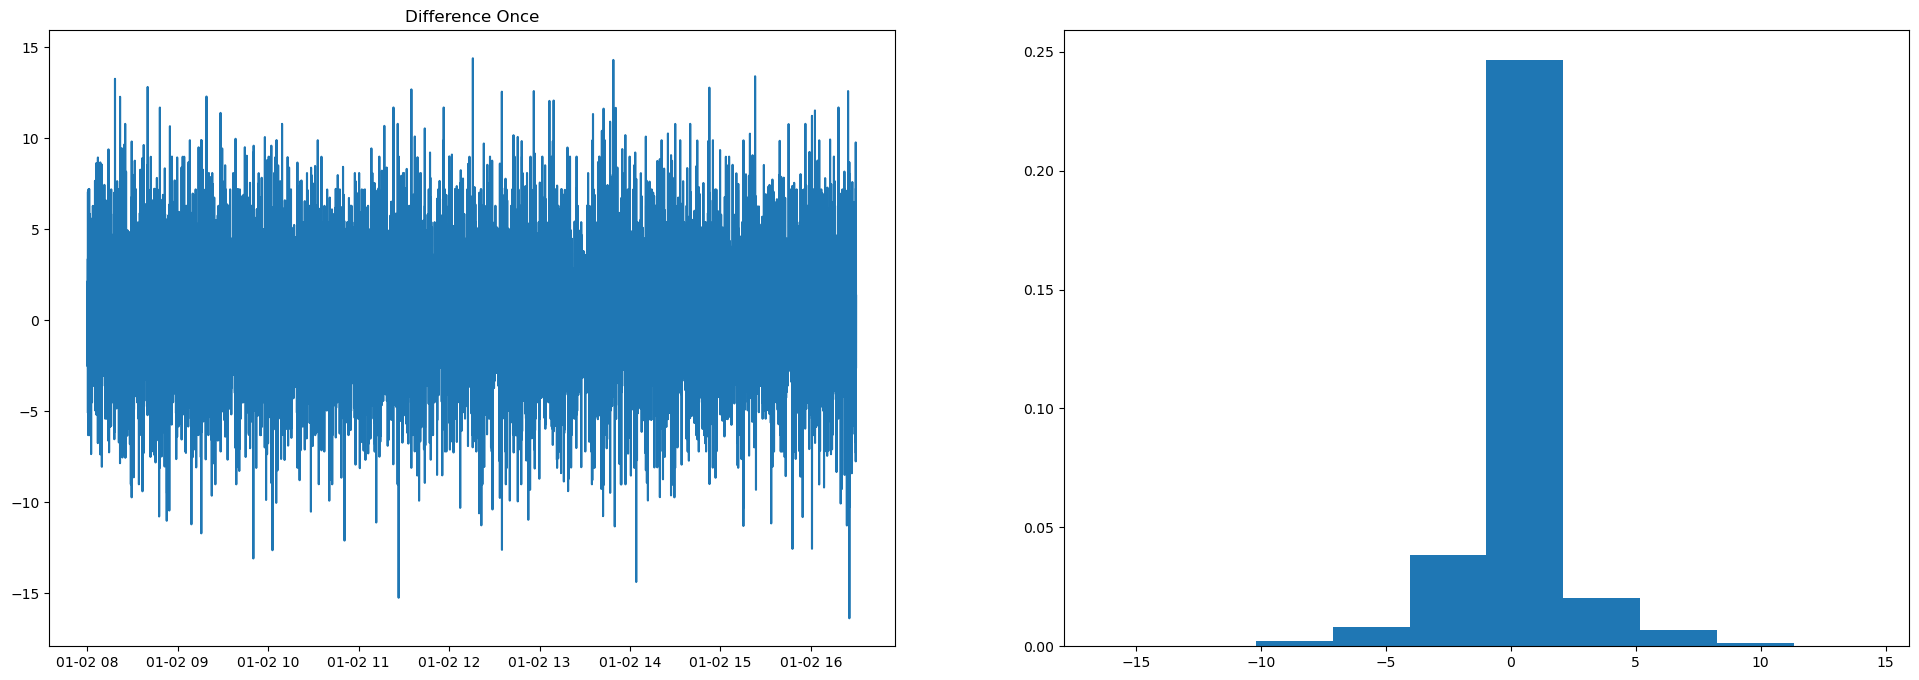

In [75]:
diff2 = pred2.diff().dropna()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

ax1.plot(diff2[1:])
ax1.set_title('Difference Once')
ax2.hist(diff2[1:], density=True)

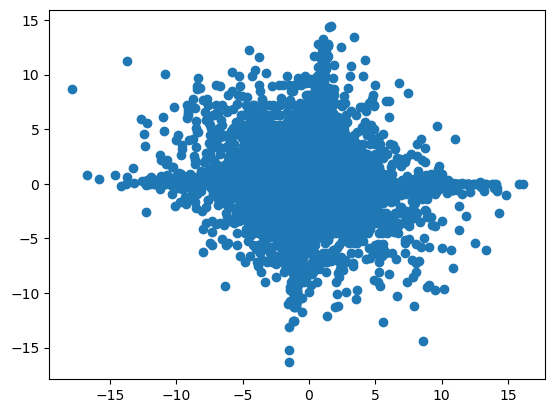

In [76]:
plt.scatter(residuals2[2:], diff2[1:])

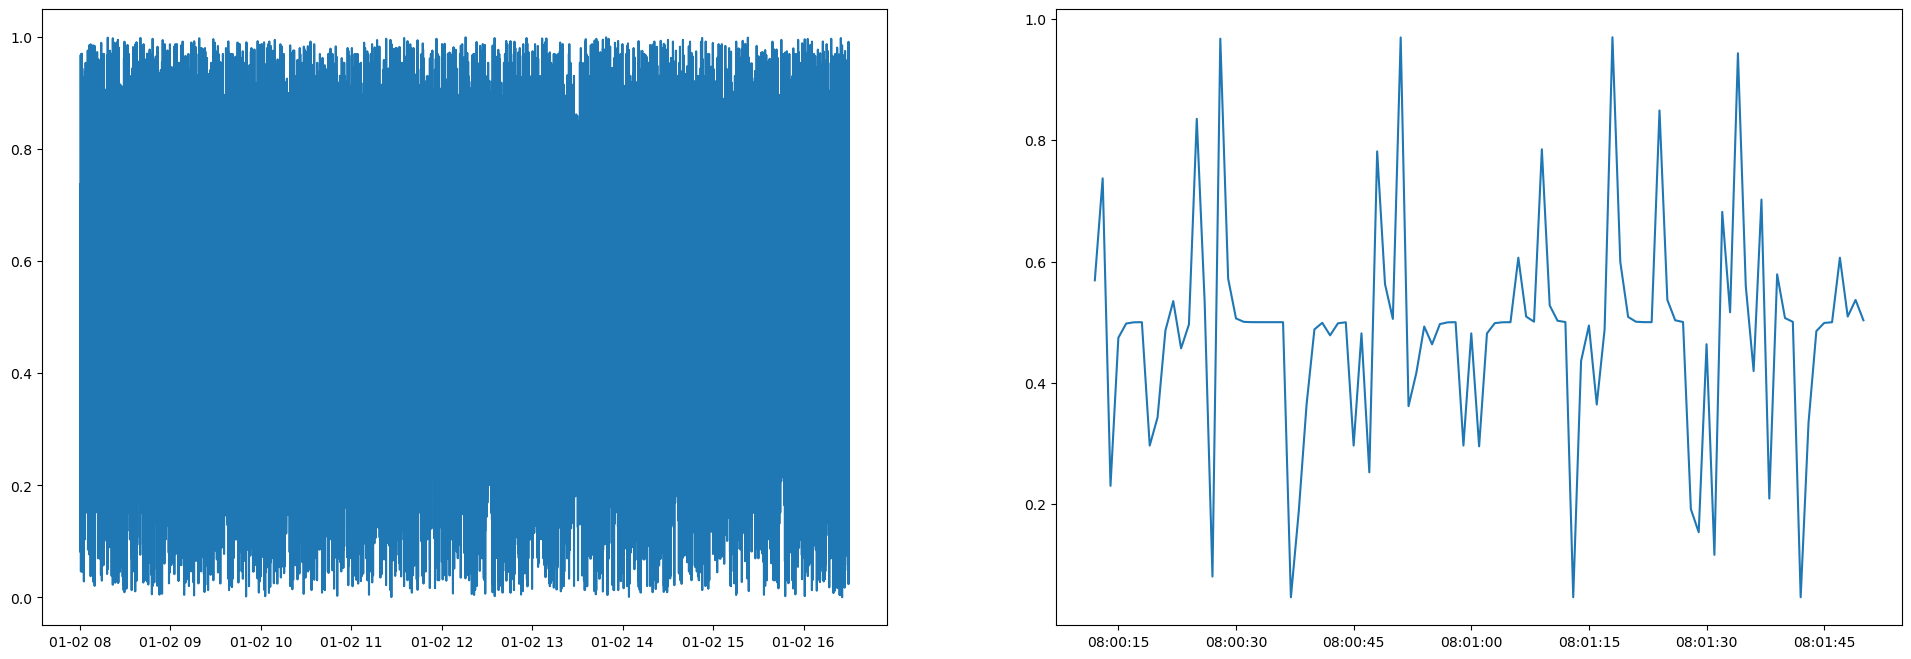

In [77]:
# pass differences through an activation function to get in 0-1 range for buy and sell signals - above 0.5 buy, below 0.5 sell
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# normalise distribtion to normal 
diff2_norm = (diff2 - diff2.mean()) / diff2.std()

singal_diff2 = sigmoid(diff2_norm)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))
ax1.plot(singal_diff2[1:])
ax2.plot(singal_diff2[1:100])

In [78]:
print('Tape 2 Error when trained on Tape 1')
print(f'Mean Absolute Error: {result2.mae}') 
print(f'MSE: {result2.mse}')

Tape 2 Error when trained on Tape 1
Mean Absolute Error: 1.2469953233220041
MSE: 5.324342560088892


Stationary Predicted Count: 10156
Stationary Actual Count: 18331
Stationary Correct Count: 5887
Upwards Predicted Count: 9489
Upwards Actual Count: 5623
Upwards Correct Count: 1445
Downwards Predicted Count: 10944
Downwards Actual Count: 6635
Downwards Correct Count: 2274
0.31403445683088693


<AxesSubplot:xlabel='combined_time'>

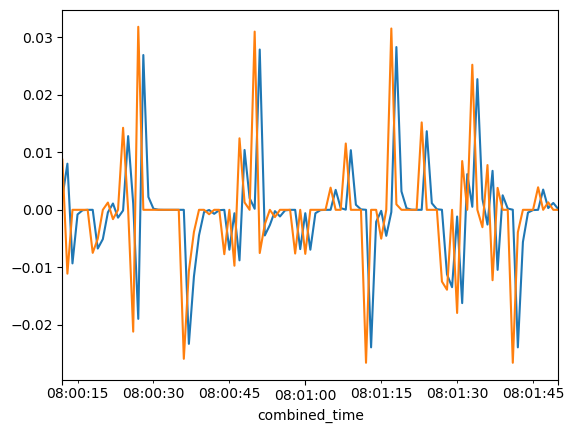

In [100]:
# check how many times signal has correctly predicted movement of actual price

# !!need to ensure that the price movement in in % values not absolute!!

# get actual price movement
actual_diff2 = tape2['Last Tapes Price'].pct_change().dropna()

pred2 = result2.predict(start=0, end=len(tape2)-1)
diff2 = pred2.pct_change().dropna()

threshold = 0.0001

# check if both are over 1/100 of a % increase
up_correct = (diff2>threshold) & (actual_diff2>threshold)
down_correct = (diff2<-threshold) & (actual_diff2<-threshold)
stationary_correct = ((diff2<=threshold) & (diff2>-threshold)) & ((actual_diff2<=threshold) & (actual_diff2>-threshold))

print(f"Stationary Predicted Count: {sum((diff2<=threshold) & (diff2>-threshold))}")
print(f"Stationary Actual Count: {sum(((actual_diff2<=threshold) & (actual_diff2>-threshold)))}")
print(f"Stationary Correct Count: {sum(stationary_correct)}")

#correct = diff2_high*actual_diff2 > 0 # correct if direction is the same
#print(f"Stationary Predicted Count: {sum(diff2_high== 0)}")
#print(f"Stationary Actual Count: {sum(actual_diff2== 0)}")
# must also check if both are zero
#correct = correct | (diff2_high == 0) & (actual_diff2 == 0)
correct = up_correct | down_correct | stationary_correct
print(f"Upwards Predicted Count: {sum(diff2>threshold)}")
print(f"Upwards Actual Count: {sum(actual_diff2>threshold)}")
print(f"Upwards Correct Count: {sum(up_correct)}")
print(f"Downwards Predicted Count: {sum(diff2<-threshold)}")
print(f"Downwards Actual Count: {sum(actual_diff2<-threshold)}")
print(f"Downwards Correct Count: {sum(down_correct)}")
print(correct.sum()/len(correct))

diff2[1:100].plot()  
actual_diff2[1:100].plot()

In [80]:
model_high = ARIMA(tape1['Last Tapes Price'], order=(4,1,4))
result_high = model_high.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [81]:
result2_high = result_high.apply(tape2['Last Tapes Price'], refit=False)
result2_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Last Tapes Price   No. Observations:                30590
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -68142.968
Date:                Wed, 06 Mar 2024   AIC                         136303.936
Time:                        16:43:39   BIC                         136378.891
Sample:                    01-02-2025   HQIC                        136327.964
                         - 01-02-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0968      0.317     -0.306      0.760      -0.717       0.524
ar.L2          0.0916      0.285      0.322      0.748      -0.466       0.649
ar.L3          0.0203      0.281      0.072      0.942      -0.530       0.571
ar.L4          0.5118      0.238      2.153      0.031       0.046       0.978
ma.L1         -0.0476      0.318     -0.150      0.881      -0.671       0.576
ma.L2         -0.2305      0.318     -0.725      0.468      -0.854       0.393
ma.L3         -0.1113      0.296     -0.376      0.707      -0.691       0.468
ma.L4         -0.5802      0.278     -2.090      0.037      -1.124      -0.036
sigma2         5.0402      0.024    213.376      0.000       4.994       5.087
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             48717.81
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.24
Prob(H) (two-sided):                  0.82   Kurtosis:                         9.16
===================================================================================

Warnings:
[1] Parameters and standard errors were estimated using a different dataset and were then applied to this dataset. Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
print('Tape 2 Error when trained on Tape 1')
print(f'Mean Absolute Error: {result2_high.mae}') 
print(f'MSE: {result2_high.mse}')

Tape 2 Error when trained on Tape 1
Mean Absolute Error: 1.3548209536565694
MSE: 7.370837960895471


In [83]:
pred2_high = result2_high.predict(start=0, end=len(tape2)-1)
diff2_high = pred2_high.diff().dropna()

threshold = 0.0001

# check if both are over 1/100 of a % increase
up_correct = (diff2_high>threshold) & (actual_diff2>threshold)
down_correct = (diff2_high<-threshold) & (actual_diff2<-threshold)
stationary_correct = ((diff2_high<=threshold) & (diff2_high>-threshold)) & ((actual_diff2<=threshold) & (actual_diff2>-threshold))

print(f"Stationary Predicted Count: {sum((diff2_high<=threshold) & (diff2_high>-threshold))}")
print(f"Stationary Actual Count: {sum(((actual_diff2<=threshold) & (actual_diff2>-threshold)))}")

#correct = diff2_high*actual_diff2 > 0 # correct if direction is the same
#print(f"Stationary Predicted Count: {sum(diff2_high== 0)}")
#print(f"Stationary Actual Count: {sum(actual_diff2== 0)}")
# must also check if both are zero
#correct = correct | (diff2_high == 0) & (actual_diff2 == 0)
correct = up_correct | down_correct | stationary_correct

print(correct.sum()/len(correct))

Stationary Predicted Count: 44
Stationary Actual Count: 18331
0.1892837294452254


Use the model to make out of sample predictions

In [84]:
model = ARIMA(tape2['Last Tapes Price'][:20000], order=(4,1,4))
result3 = model.fit()

c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\benjo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [85]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Last Tapes Price   No. Observations:                20000
Model:                 ARIMA(4, 1, 4)   Log Likelihood              -44379.094
Date:                Wed, 06 Mar 2024   AIC                          88776.188
Time:                        16:43:56   BIC                          88847.319
Sample:                    01-02-2025   HQIC                         88799.460
                         - 01-02-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0370      0.395     -0.094      0.925      -0.810       0.736
ar.L2          0.0568      0.349      0.163      0.871      -0.627       0.740
ar.L3         -0.0261      0.345     -0.076      0.940      -0.702       0.650
ar.L4          0.5281      0.290      1.818      0.069      -0.041       1.097
ma.L1         -0.1095      0.397     -0.276      0.782      -0.887       0.668
ma.L2         -0.1944      0.399     -0.487      0.626      -0.977       0.588
ma.L3         -0.0659      0.354     -0.186      0.852      -0.760       0.629
ma.L4         -0.5987      0.339     -1.766      0.077      -1.263       0.066
sigma2         4.9535      0.029    169.665      0.000       4.896       5.011
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):             29468.79
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')

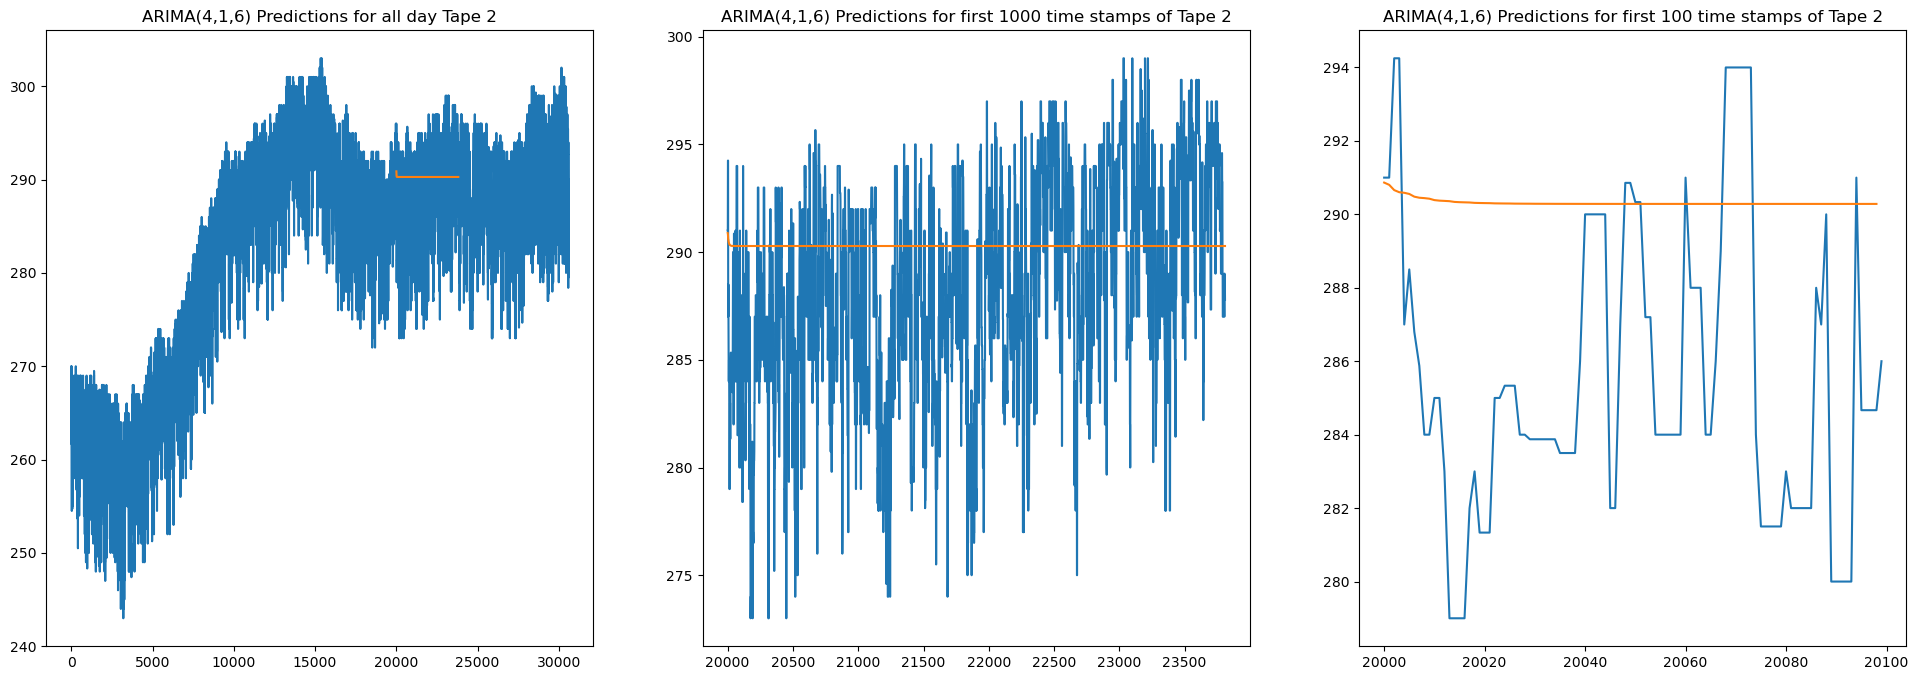

In [91]:
pred2 = result3.forecast(steps = 3810)
forecast_range = np.arange(20000,23810)
total_range = np.arange(0,30590)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))

ax1.plot(total_range,tape2['Last Tapes Price'])
ax1.plot(forecast_range,pred2)
ax1.set_title('ARIMA(4,1,6) Predictions for all day Tape 2')

ax2.plot(forecast_range,tape2['Last Tapes Price'][20000:23810])
ax2.plot(forecast_range,pred2)
ax2.set_title('ARIMA(4,1,6) Predictions for first 1000 time stamps of Tape 2')

ax3.plot(np.arange(20000,20100),tape2['Last Tapes Price'][20000:20100])
ax3.plot(forecast_range[0:99],pred2[1:100]) 
ax3.set_title('ARIMA(4,1,6) Predictions for first 100 time stamps of Tape 2')